In [142]:
import sqlite3
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

#Just supressing some warnings
warnings.filterwarnings("ignore", category=FutureWarning)


DB_PATH = "../data/database.db"

# Step 1: Load and expand genres from SQLite
def load_movies_with_genres(db_path):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql("SELECT * FROM movies", conn)
    conn.close()
    
    # Parse JSON string into lists
    df['genres'] = df['genres'].apply(json.loads)

    # Explode genres into separate rows for analysis
    df_exploded = df.explode('genres')
    
    return df, df_exploded

df, df_exploded = load_movies_with_genres(DB_PATH)



1066


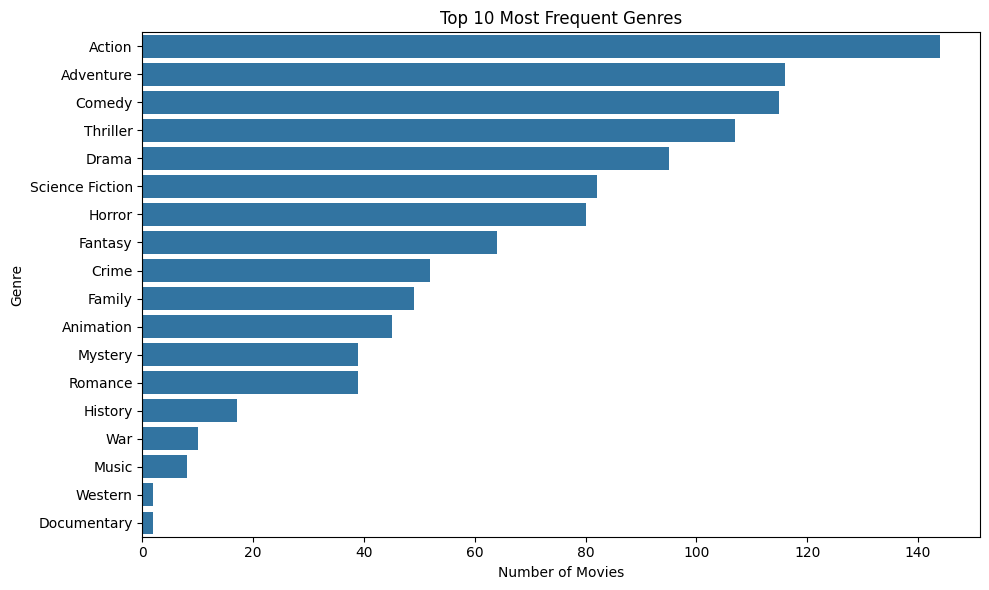

In [177]:
# Step 2: Top 10 most frequent genres
genre_counts = df_exploded['genres'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Top 10 Most Frequent Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()



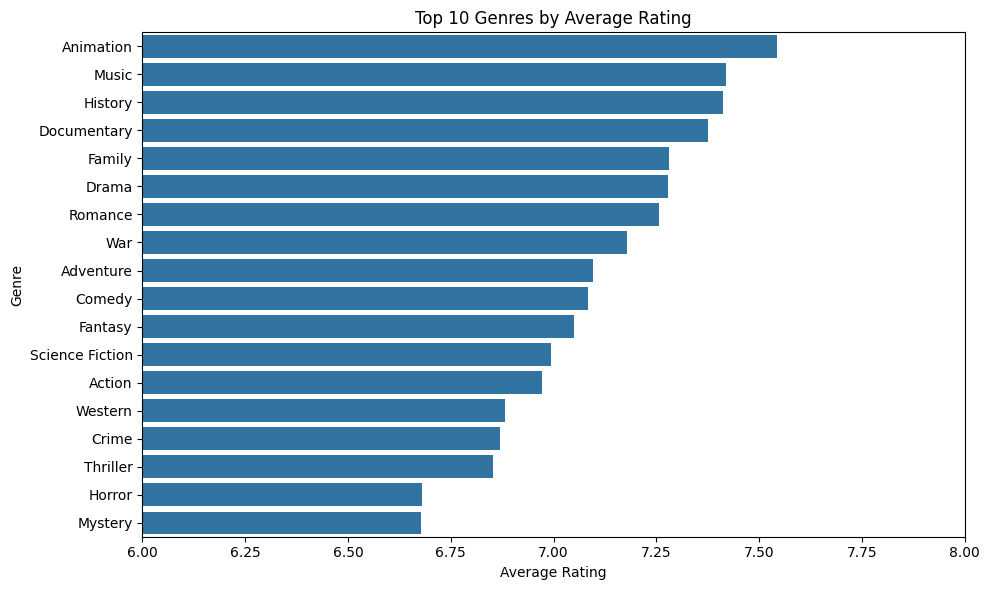

In [173]:

# Step 3: Average rating per genre
genre_avg_rating = df_exploded.groupby('genres')['vote_average'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_avg_rating.values, y=genre_avg_rating.index)
plt.title("Top 10 Genres by Average Rating")
plt.xlabel("Average Rating")
plt.xlim(6, 8)

plt.ylabel("Genre")
plt.tight_layout()
plt.show()



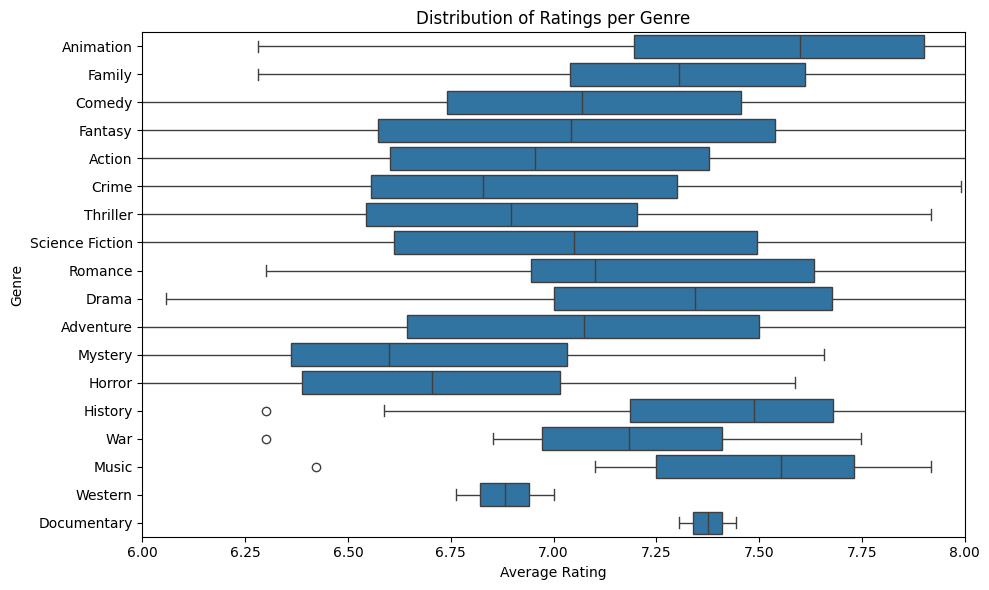

In [172]:
# Step 3: Boxplot of vote_average per genre
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exploded, x='vote_average', y='genres')

plt.title("Distribution of Ratings per Genre")
plt.xlabel("Average Rating")
plt.xlim(6, 8)  # Limit x-axis from 6 to 8
plt.ylabel("Genre")

plt.tight_layout()
plt.show()


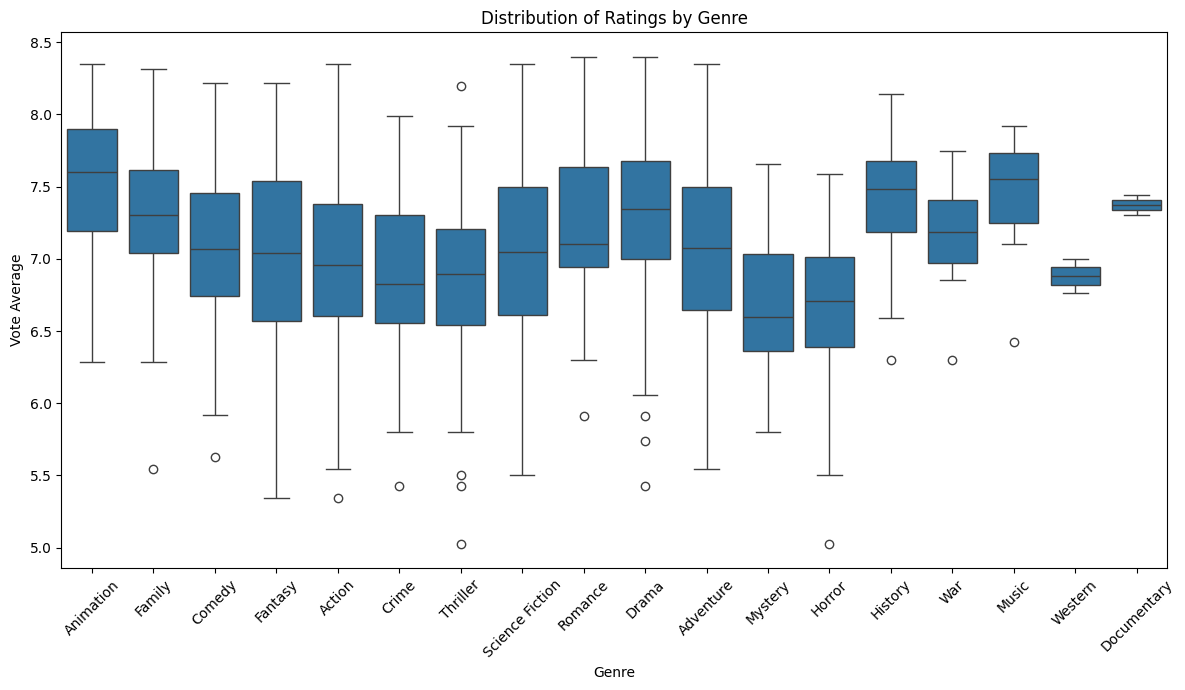

In [178]:
# Step 4: Box plot of vote_average by top genres
top_genres = genre_counts.index.tolist()
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
            x='genres', y='vote_average')
plt.title("Distribution of Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("Vote Average")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


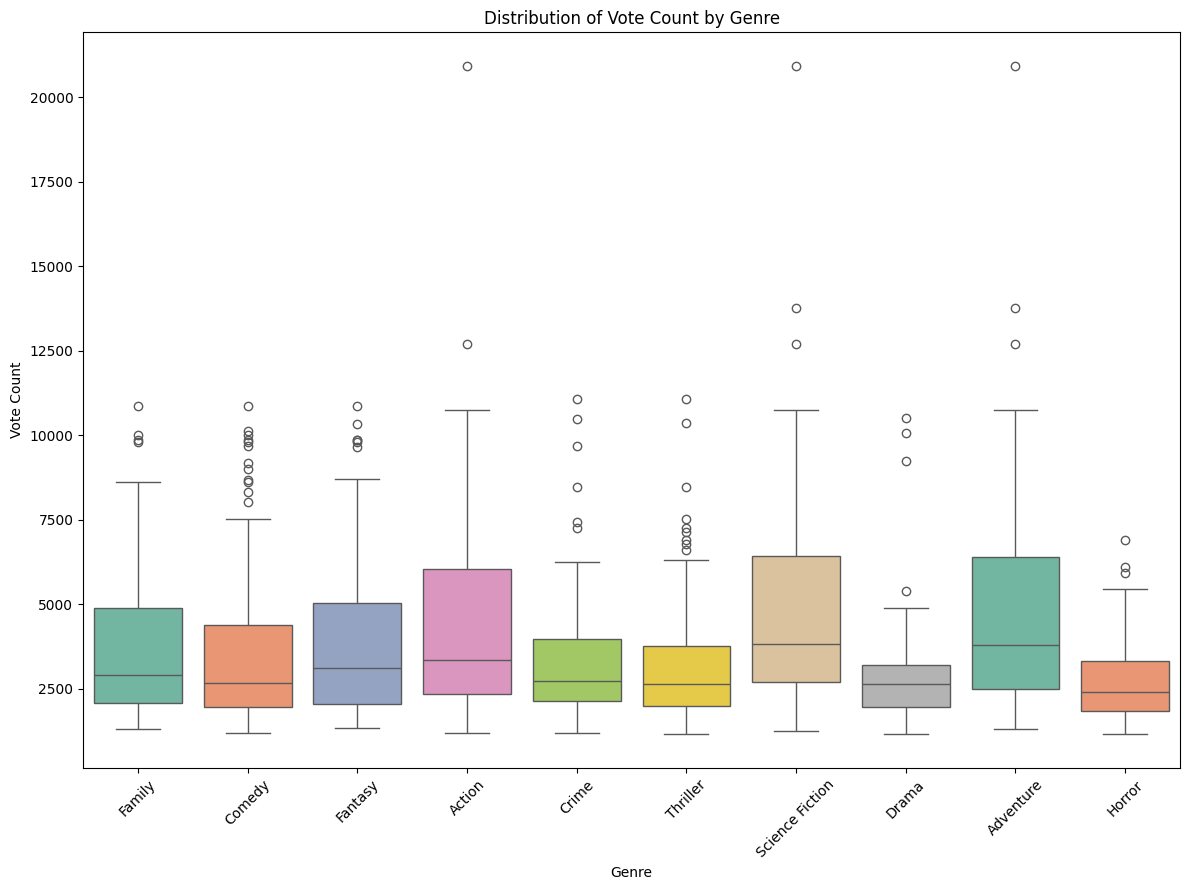

In [130]:
plt.figure(figsize=(12, 9))
sns.boxplot(data=df_exploded[df_exploded['genres'].isin(top_genres)],
            x='genres', y='vote_count', palette='Set2')
# plt.yscale('log')  # Removed log scale
plt.title("Distribution of Vote Count by Genre")
plt.xlabel("Genre")
plt.ylabel("Vote Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [145]:
# Define lower and higher bins
lower_bin = '0-2500'
higher_bin = '>17500'
# Create bins and labels (adjust the ranges as per your dataset)
bins = [0, 2500, 5000, 10000, 17500, df['vote_count'].max()]
labels = ['0-2500', '2500-5000', '5000-10000', '10000-17500', '>17500']
df['vote_count_bin'] = pd.cut(df['vote_count'], bins=bins, labels=labels, right=False)

# Assign bin labels to a new column

# Filter movies in the lower bin, sort by rating descending, show top 5
lower_movies = df[df['vote_count_bin'] == lower_bin] \
                .sort_values('vote_average', ascending=False) \
                .head(5)

# Filter movies in the higher bin, sort by rating descending, show top 5
higher_movies = df[df['vote_count_bin'] == higher_bin] \
                 .sort_values('vote_average', ascending=False) \
                 .head(5)

print(f"Top 5 movies with low votes ({lower_bin}):")
print(lower_movies[['title', 'vote_count', 'vote_average']])

print("\nTop 5 movies with high votes (>{}):".format(higher_bin))
print(higher_movies[['title', 'vote_count', 'vote_average']])


Top 5 movies with low votes (0-2500):
                                  title  vote_count  vote_average
45                    Gabriel's Inferno        2427         8.400
67           Gabriel's Inferno: Part II        1527         8.379
52                       Life in a Year        1922         8.243
335                                Flow        2151         8.200
69   Justice League Dark: Apokolips War        1501         8.200

Top 5 movies with high votes (>>17500):
Empty DataFrame
Columns: [title, vote_count, vote_average]
Index: []


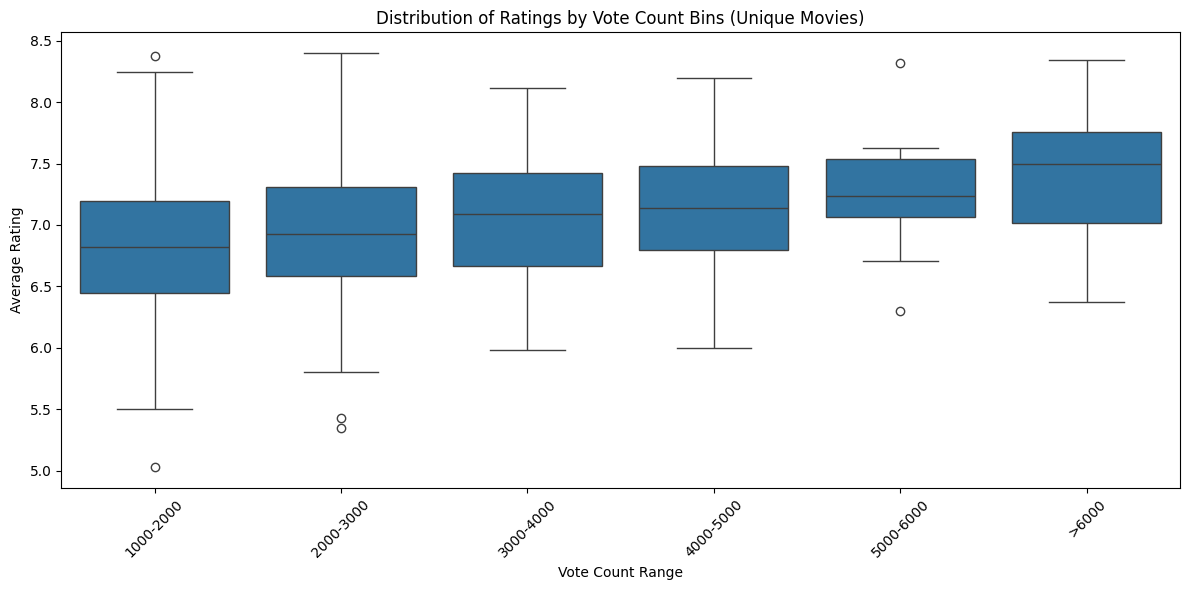

In [146]:

# Define bins and labels starting from 500
bins = [1000, 2000, 3000, 4000, 5000, 6000, float('inf')]
bin_labels = ['1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '>6000']

# Bin vote counts (before deduplication)
df['vote_count_bin'] = pd.cut(
    df['vote_count'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
    right=False
)

# Drop duplicates to count each movie once
df_unique = df.drop_duplicates(subset='title')

# Plot boxplot on unique movies only
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_unique, x='vote_count_bin', y='vote_average')
plt.xticks(rotation=45)
plt.title('Distribution of Ratings by Vote Count Bins (Unique Movies)')
plt.xlabel('Vote Count Range')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


In [147]:
counts_per_bin = df['vote_count_bin'].value_counts().sort_index()
print(counts_per_bin)


vote_count_bin
1000-2000     94
2000-3000    119
3000-4000     62
4000-5000     29
5000-6000     14
>6000         57
Name: count, dtype: int64


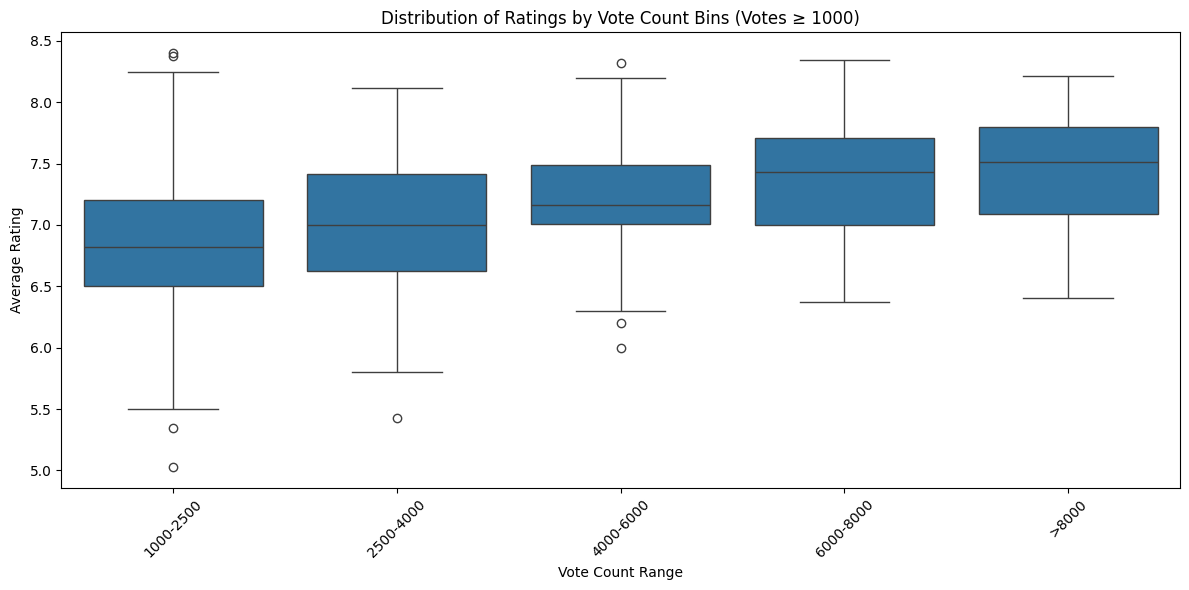

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt


# Define new bins and labels
bins = [1000, 2500, 4000, 6000, 8000, float('inf')]
bin_labels = ['1000-2500', '2500-4000', '4000-6000', '6000-8000',">8000"]

# Bin vote counts
df['vote_count_bin'] = pd.cut(df['vote_count'],
                                       bins=bins,
                                       labels=bin_labels,
                                       include_lowest=True)

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='vote_count_bin', y='vote_average')
plt.xticks(rotation=45)
plt.title('Distribution of Ratings by Vote Count Bins (Votes ≥ 1000)')
plt.xlabel('Vote Count Range')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


In [161]:
print(df['vote_count_bin'].value_counts().sort_index())


vote_count_bin
1000-2500    154
2500-4000    121
4000-6000     43
6000-8000     27
>8000         30
Name: count, dtype: int64


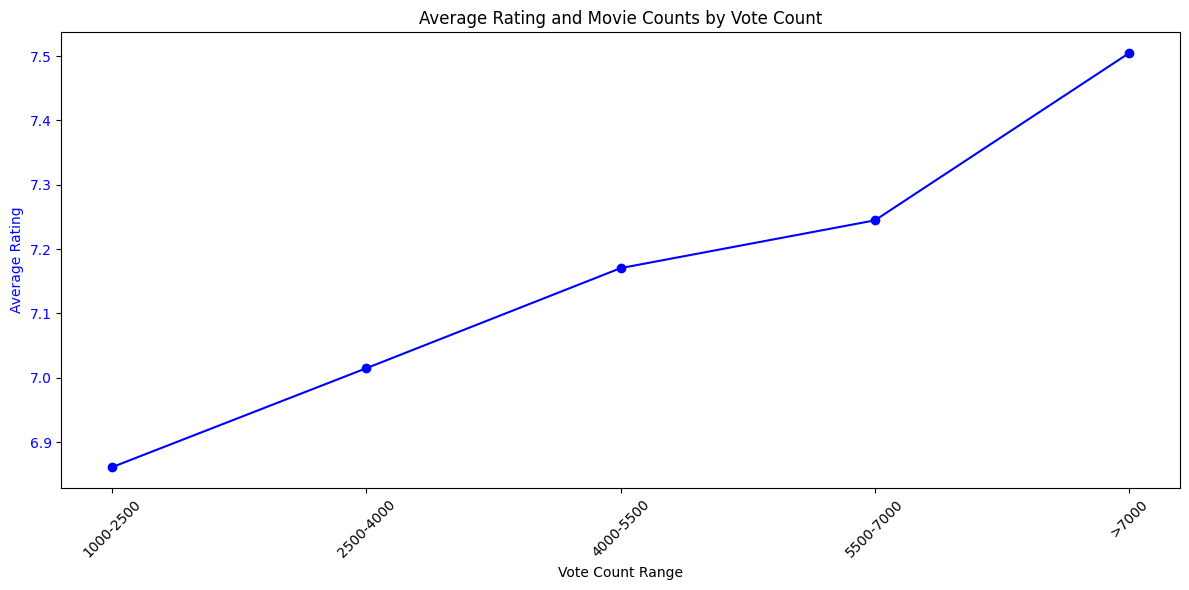

In [154]:
# Filter movies with vote_count >= 500 (if needed)
# Assuming df already filtered or you can add this:
df = df[df['vote_count'] >= 500]

# Define bins and labels
bins = [1000, 2500, 4000, 5500, 7000, float('inf')]
bin_labels = ['1000-2500', '2500-4000', '4000-5500', '5500-7000', '>7000']

# Bin vote counts
df['vote_count_bin'] = pd.cut(df['vote_count'],
                              bins=bins,
                              labels=bin_labels,
                              include_lowest=True)

# Calculate average rating per bin
avg_rating_per_bin = df.groupby('vote_count_bin')['vote_average'].mean()

# Count number of movies per bin (since df is unique, this is the unique movie count)
movie_counts_per_bin = df['vote_count_bin'].value_counts().reindex(bin_labels).fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(bin_labels))

# Line plot for average rating
ax1.plot(x, avg_rating_per_bin.values, marker='o', color='b', label='Average Rating')
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_xlabel('Vote Count Range')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# # Twin axis for movie counts bar plot
# ax2 = ax1.twinx()
# ax2.bar(x, movie_counts_per_bin.values, alpha=0.3, color='gray', label='Movie Count')
# ax2.set_ylabel('Number of Movies', color='gray')
# ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Average Rating and Movie Counts by Vote Count')
plt.tight_layout()
plt.show()
